In [1]:
%cd ..

/JaxDeepSPDE


In [2]:
import os
import sys
import inspect
import importlib
from datetime import datetime
from functools import partial
import matplotlib.pyplot as plt
from skimage.transform import radon, iradon
import jax
import jax.numpy as np
import numpy as onp
import jax.experimental.optimizers as jopt
import jax.random as jrandom
from jax import jit, value_and_grad
from tqdm import trange

In [3]:
from utils import metric, symmetrize
from utils import add_boolean_argument, set_plot
from utils.hdf_io import save_to_hdf
from DeepSPDE import Fourier, RandomGenerator, LMatrixGenerator
from Optimizers import hessian_free, adahessian, value_grad_and_hessian
from post_processing import process_nwd_results
from utils.loss_function_and_support import from_complex_w_halfs_to_ravelled_reals, from_two_reals_ravelled_to_complex, \
    non_analytical_mean_and_std, loss, output_fun
from Measurements import Sinogram
from Phantom import contrast_shepp_logan_ellipses,original_shepp_logan_ellipses,\
    single_ellipse, multi_ellipses_fun, scale_ellipses
from Optimizers import OptimizerType
os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=/usr/local/cuda"

In [4]:
fig_size, lw, marker_size = set_plot(use_latex=True)

In [5]:
optimizer = OptimizerType.ADA_HESSIAN
fourier_basis_number = 16
fourier_target_number = 64
n_theta = 45
n_p_prime = 2*fourier_target_number-1
measurement_samples_number = 1
measurement_variance = 0.09
n_prior_layers = 1
n_sigmas = n_prior_layers+1
use_randomized_initialization = False
learn_sigmas = True
momentum = 0.1
random_seed = 0
random_loop_length = 1000
required_max_loss_val = 100000
cg_max_iter = 100
n_samples = 100
kappa0 = 1e0
n_steps = 10000
use_soft_max = False
use_gnm = False
step_scale = 1e-1
if n_prior_layers>1:
    step_scale = 1e-3
    momentum = 0.1
    kappa0 = 1e1
if optimizer == OptimizerType.HESSIAN_FREE:
    kappa0 = 1e0#1e0
    n_steps=100
    step_scale = 1e0
    use_soft_max = False
elif optimizer == OptimizerType.ADA_HESSIAN:
    step_scale = 1e-1
    adahessian_b1 = 0.9
    adahessian_b2 = 0.999
elif optimizer == OptimizerType.ADAM:
    kappa = 1e0
    step_scale = 1e-1
    adam_b1 = 0.1
    adam_b2 = 0.1

In [6]:
f = Fourier(fourier_basis_number, fourier_target_number, 2)
if use_soft_max:
    kappa_fun = lambda x: np.log(np.exp(x) + 1)
    l_matrix = LMatrixGenerator(f, kappa0=kappa0, kappa_fun=kappa_fun)
else:
    l_matrix = LMatrixGenerator(f, kappa0=kappa0)

In [7]:
scale = n_p_prime
std_dev = np.sqrt(measurement_variance)
thetas = onp.linspace(0, 1, n_theta, endpoint=False) * onp.pi
sino = Sinogram(contrast_shepp_logan_ellipses,f,thetas,n_p_prime,std_dev=std_dev)
y_ = sino.measure().ravel()

JaxDeepSPDE/Phantom/ellipse.py:178: RuntimeWarning: invalid value encountered in sqrt
  distance = 2 * a * onp.sqrt(factor_1) / factor_2


In [8]:
# plt.figure(figsize=fig_size)
# plt.imshow(sino.ground_truth,origin="lower",cmap=plt.cm.gray)

Seeing the original phantom

In [9]:
# t_points = np.linspace(-0.5,0.5,n_p_prime) # this is the default settings
# x_points,y_points = np.meshgrid(t_points,t_points)
# phantom_shepp_logan = multi_ellipses_fun(x_points,y_points,contrast_shepp_logan_ellipses)
# plt.figure(figsize=fig_size)
# plt.imshow(phantom_shepp_logan,origin="lower",cmap=plt.cm.gray)

The sinogram obtained via radon function from skimage

The sinogram from skimage:

In [10]:
# sino_skimage = radon(phantom_shepp_logan,theta=thetas*180/onp.pi)
# fig = plt.figure(figsize=fig_size)
# im = plt.imshow(sino_skimage,origin="lower",cmap=plt.cm.gray)
# fig.colorbar(im)

In [11]:
# fig = plt.figure(figsize=fig_size)
# im = plt.imshow(sino.ground_truth-sino_skimage/scale,origin="lower",vmin=-.08, vmax=0.08, cmap=plt.cm.seismic_r)
# fig.colorbar(im)

In [12]:
identity = np.eye(2 * f.basis_number - 1)
meas_samples = sino.measure().ravel(sino.ravel_order)
identity_m = np.eye(meas_samples.shape[0])
normalized_meas_samples = np.asarray(meas_samples, dtype=np.float32) / sino.std_dev
sino.measurement_matrix
h_matrix = np.asarray(sino.measurement_matrix, dtype=np.complex64) / sino.std_dev
h_conj_t = h_matrix.conj().T

@partial(jit, static_argnums=(1,))
def wrapped_loss(whalfs_real, whalfs_shape, sigmas_in, y):
    w_halfs_in = from_two_reals_ravelled_to_complex(whalfs_real, whalfs_shape)
    return loss(w_halfs_in, sigmas_in, y, h_conj_t, identity_m, l_matrix)

@partial(jit, static_argnums=(2,))
def wrapped_output_fun(sigmas_in, whalfs_real, whalfs_shape, y):
    w_halfs_in = from_two_reals_ravelled_to_complex(whalfs_real, whalfs_shape)
    return output_fun(w_halfs_in, sigmas_in, y, h_conj_t, identity_m, l_matrix)

rg = RandomGenerator(f.essential_basis_number, f.dimension)
picked_whalfs = np.zeros((n_prior_layers, f.basis_number), dtype=np.complex64)
if optimizer in [OptimizerType.HESSIAN_FREE, OptimizerType.ADA_HESSIAN]:
    picked_whalfs = rg.construct_w_half(n_prior_layers)
picked_log_sigmas = np.zeros(n_prior_layers + 1)
sigmas = np.ones(n_prior_layers + 1)

JaxDeepSPDE/Phantom/sinogram_operator.py:30: RuntimeWarning: invalid value encountered in true_divide
  factor = (np.sin(2 * np.pi * k_tilde_v * np.outer(el, one_i))) / (np.pi * k_tilde_v)


In [13]:
if use_randomized_initialization:
    print('Use a randomized initial condition ...')
    picked_val = np.inf
    loss_val = np.nan
    prngkey = jrandom.PRNGKey(random_seed)
    w_halfs_many = rg.construct_w_half(n_prior_layers * random_loop_length)
    w_halfs_many = w_halfs_many.reshape((random_loop_length, n_prior_layers, l_matrix.fourier.basis_number))
    prngkey, subkeys = jrandom.split(prngkey)
    log_sigmas = jrandom.normal(subkeys, shape=(random_loop_length, n_prior_layers + 1))
    for i in trange(random_loop_length):
        sigmas = np.exp(picked_log_sigmas + log_sigmas[i])
        w_halfs = picked_whalfs + w_halfs_many[i]
        loss_val = loss(w_halfs, sigmas,
                        normalized_meas_samples,
                        h_conj_t, identity_m, l_matrix).block_until_ready()  # test with first measurement

        if loss_val < 0.:  # below zero seems an invalid value
            continue

        if loss_val < picked_val:
            picked_val = loss_val
            picked_whalfs = w_halfs
            picked_log_sigmas = np.log(sigmas)
            print('update picked_val to {}'.format(picked_val))
        if picked_val < required_max_loss_val:
            break

In [14]:
if optimizer in [OptimizerType.HESSIAN_FREE, OptimizerType.ADA_HESSIAN]:
    sigmas = np.exp(picked_log_sigmas)
    w_halfs_real, w_halfs_shape = from_complex_w_halfs_to_ravelled_reals(picked_whalfs)
    if learn_sigmas:
        state_init = np.concatenate((sigmas,w_halfs_real))
    else:
        state_init = w_halfs_real
    
    if optimizer == OptimizerType.ADA_HESSIAN:
        opt = adahessian(step_size=step_scale,b1=adahessian_b1,b2=adahessian_b2)
        rng = jax.random.PRNGKey(1)
        opt_state = opt.init_fn(state_init)

else:
    if learn_sigmas:
        state_init = (sigmas,picked_whalfs.copy())
    else:
        state_init = (picked_whalfs.copy(),)
    
    if optimizer == OptimizerType.ADAM:
        opt = jopt.adam(step_size=step_scale,b1=adam_b1,b2=adam_b2)
        opt_state = opt.init_fn(state_init)
    elif optimizer == OptimizerType.RMSPROP:
        opt = jopt.rmsprop(step_size=step_scale)
        opt_state = opt.init_fn(state_init)
    elif optimizer == OptimizerType.RMSPROP_MOMENTUM:
        opt = jopt.rmsprop_momentum(step_size=step_scale, momentum=momentum)
        opt_state = opt.init_fn(state_init)

In [15]:
simulation_time_string = datetime.now().strftime("%d_%m_%Y_%H_%M_%S")
simulation_id = simulation_time_string + '_n_prior_layers' + str(n_prior_layers)

loss_val_list = []
nu_val_list = []
v_mean_list = []
v_std_list = []
kappa_list = []
end_state_list = []

In [16]:
# end_state = opt.params_fn(opt_state)
# if optimizer in [OptimizerType.ADA_HESSIAN, OptimizerType.HESSIAN_FREE]:
#     if learn_sigmas:
#         sigmas = end_state[:n_sigmas]
#         w_halfs_real = end_state[n_sigmas:]
#     else:
#         w_halfs_real = end_state
#     w_halfs = from_two_reals_ravelled_to_complex(w_halfs_real,(2,n_prior_layers,f.basis_number))
# else:
#     if learn_sigmas:
#         (w_halfs,sigmas) = opt.params_fn(opt_state)
#     else:
#         (w_halfs,) = opt.params_fn(opt_state)
# v_mean, v_std = non_analytical_mean_and_std(w_halfs,sigmas,h_matrix,y,1,l_matrix,f,rg)
# plt.figure(figsize=fig_size)
# plt.imshow(v_mean,cmap=plt.cm.seismic_r, origin='upper')

In [17]:
# u_min_1 = symmetrize(l_matrix.u_half_min_1,False).reshape(f.symmetric_shape,order=sino.ravel_order)
# kappa = l_matrix.kappa_fun(f.irfft(u_min_1[:, f.essential_basis_number - 1:]))
# plt.figure(figsize=fig_size)
# plt.imshow(1/kappa,cmap=plt.cm.seismic_r, origin='upper')

In [22]:
y = normalized_meas_samples
if optimizer in [OptimizerType.HESSIAN_FREE, OptimizerType.ADA_HESSIAN]:
    def re_wrapped_loss(state_real, whalfs_shape=(2, n_prior_layers, f.basis_number),
                        num_sigmas=n_sigmas):
        sigmas_in = np.ones(num_sigmas)
        w_real = state_real
        return wrapped_loss(w_real, whalfs_shape, sigmas_in, y)

    def re_wrapped_output_fun(state_real, whalfs_shape=(2, n_prior_layers, f.basis_number),
                              num_sigmas=n_sigmas):
        sigmas_in = np.ones(num_sigmas)
        w_real = state_real
        return wrapped_output_fun(sigmas_in, w_real, whalfs_shape, y)
    
    def re_wrapped_loss_b(state_real, whalfs_shape=(2, n_prior_layers, f.basis_number),
                        num_sigmas=n_sigmas):
        sigmas_in = state_real[:num_sigmas]
        w_real = state_real[num_sigmas:]
    
        return wrapped_loss(w_real, whalfs_shape, sigmas_in, y)

    def re_wrapped_output_fun_b(state_real, whalfs_shape=(2, n_prior_layers, f.basis_number),
                              num_sigmas=n_sigmas):
        sigmas_in = state_real[:n_sigmas]
        w_real = state_real[n_sigmas:]
        return wrapped_output_fun(sigmas_in, w_real, whalfs_shape, y)

    if use_gnm:
        if learn_sigmas:
            fun = re_wrapped_output_fun_b
        else:
            fun = re_wrapped_output_fun
    else:
        if learn_sigmas:
            fun = re_wrapped_loss_b
        else:
            fun = re_wrapped_loss

    if optimizer == OptimizerType.HESSIAN_FREE:
        state_hist, nu_hist, value_hist = hessian_free(fun, state_init, n_steps=n_steps,
                                                       use_gnm=use_gnm,
                                                       cg_max_iter=cg_max_iter,
                                                       learning_rate=step_scale)
        if learn_sigmas:
            sigmas = state_hist[-1, :n_sigmas]
            w_halfs_real = state_hist[-1, n_sigmas:]
        else:
            w_halfs_real = state_hist[-1, :]
            
        end_state_list.append(state_hist[-1, :])

    # ADA_HESSIAN
    else:
        def optimizer_step(step, opt_state, rng):
            if learn_sigmas:
                fun = re_wrapped_loss_b
            else:
                fun = re_wrapped_loss
                
            val, gradient, hessian = value_grad_and_hessian(fun, (opt.params_fn(opt_state),), rng,
                                                            argnum=0)
            if np.isnan(val):
                raise StopIteration
            if np.any(np.isnan(gradient)) or np.any(np.isnan(hessian)):
                raise StopIteration
            opt_state = opt.update_fn(step, gradient, hessian, opt_state)
            return val, opt_state

        value_hist = []
        opt_state = opt.init_fn(state_init)

        try:
            with trange(n_steps) as tr:
                for step in tr:
                    rng, rng_param = jax.random.split(rng)
                    val, opt_state = optimizer_step(step, opt_state, rng_param)
                    value_hist.append(val)
                    tr.set_description('Current loss value = {:.4f}'.format(val))

        except StopIteration:
            print('Nan value found in the gradient. Stopping the optimization loop')
        finally:
            end_state = opt.params_fn(opt_state)
            if learn_sigmas:
                sigmas = end_state[:n_sigmas]
                w_halfs_real = end_state[n_sigmas:]
            else:
                w_halfs_real = end_state
            end_state_list.append(end_state)

        if not value_hist:
            value_hist = np.array([np.inf])
        else:
            value_hist = np.stack(value_hist)

    w_halfs = from_two_reals_ravelled_to_complex(w_halfs_real, (2, n_prior_layers, f.basis_number))

elif optimizer in [OptimizerType.ADAM, OptimizerType.RMSPROP, OptimizerType.RMSPROP_MOMENTUM]:
    def re_wrapped_loss(w_halfs_in):
        val = loss(w_halfs_in, sigmas, y, h_conj_t, identity_m, l_matrix)
        return val
    
    def re_wrapped_loss_b(w_halfs_in, sigmas_in):
        val = loss(w_halfs_in, sigmas_in, y, h_conj_t, identity_m, l_matrix)
        return val

    if learn_sigmas:
        state_init = (picked_whalfs.copy(),sigmas.copy())
        opt_state = opt.init_fn(state_init)
        (w_halfs,sigmas) = opt.params_fn(opt_state)
        fun = re_wrapped_loss_b
        loss_grad_and_val = jit(value_and_grad(fun, argnums=(0,1)))
    else:
        state_init = (picked_whalfs.copy(),)
        opt_state = opt.init_fn(state_init)
        (w_halfs, ) = opt.params_fn(opt_state)
        fun = re_wrapped_loss
        loss_grad_and_val = jit(value_and_grad(fun, argnums=(0,)))

    def optimizer_step(step, state):
        val, grads = loss_grad_and_val(*opt.params_fn(state))
        if np.isnan(val):
            raise StopIteration
        if np.any(np.isnan(grads[0])):
            raise StopIteration
        state = opt.update_fn(step, grads, state)
        return val, state

    value_hist = []
    try:
        with trange(n_steps) as tr:
            for step in tr:
                val, opt_state = optimizer_step(step, opt_state)
                value_hist.append(val)
                tr.set_description('Current loss value = {:.4f}'.format(val))
    except StopIteration:
        print('Nan value found in the gradient. Stopping the optimization loop')
    finally:
        if learn_sigmas:
            (w_halfs,sigmas) = opt.params_fn(opt_state)
        else:
            (w_halfs,) = opt.params_fn(opt_state)
        end_state_list.append(w_halfs)


    if not value_hist:
        value_hist = np.array([np.inf])
    else:
        value_hist = np.stack(value_hist)

Current loss value = 3370.6096:  13%|█▎        | 1275/10000 [32:30<3:42:24,  1.53s/it]


KeyboardInterrupt: 

In [26]:
end_state = opt.params_fn(opt_state)
if optimizer in [OptimizerType.ADA_HESSIAN, OptimizerType.HESSIAN_FREE]:
    if learn_sigmas:
        sigmas = end_state[:n_sigmas]
        w_halfs_real = end_state[n_sigmas:]
    else:
        w_halfs_real = end_state
    w_halfs = from_two_reals_ravelled_to_complex(w_halfs_real,(2,n_prior_layers,f.basis_number))
else:
    if learn_sigmas:
        (w_halfs,sigmas) = opt.params_fn(opt_state)
    else:
        (w_halfs,) = opt.params_fn(opt_state)
v_mean, v_std = non_analytical_mean_and_std(w_halfs,sigmas,h_matrix,y,1,l_matrix,f,rg)
plt.figure(figsize=fig_size)
plt.imshow(v_mean,cmap=plt.cm.seismic_r, origin='upper')

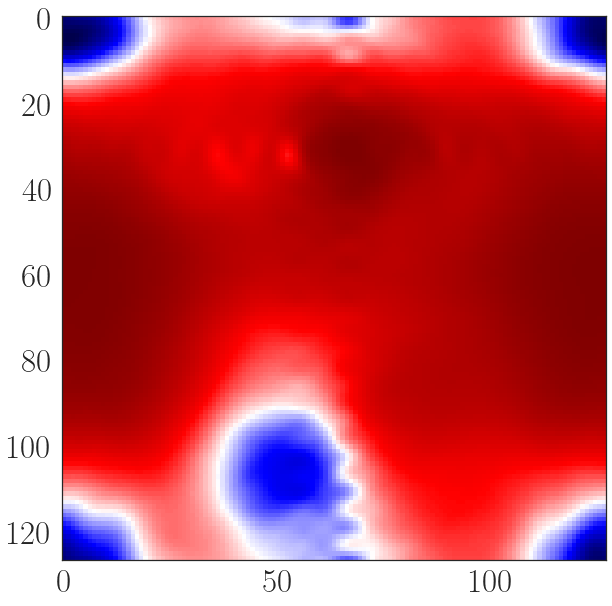

In [25]:
u_min_1 = symmetrize(l_matrix.u_half_min_1,False).reshape(f.symmetric_shape,order=sino.ravel_order)
kappa = l_matrix.kappa_fun(f.irfft(u_min_1[:, f.essential_basis_number - 1:]))
plt.figure(figsize=fig_size)
plt.imshow(1/kappa,cmap=plt.cm.seismic_r, origin='upper')